# 金融市场情绪专题
PCA

In [1]:
import sys
import os
import cudf
import cupy
import pandas as pd

# 自行编写的包


sys.path.append('/usr/local/stata17/utilities')
sys.path.append('/home/ubuntu/notebook/pycharm_projects/Investor-Sentiment')

# Stata
from pystata import config

config.init('mp')
# ------------------------------数据集路径----------------------------------#
# /usr/local/miniconda3/envs/Rapids/bin/python
DATASETS_PATH = '/data/DataSets/BW_INDEX_CSMAR/BW_5_CSMAR/'


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 8-core , expiring  1 Jan 2025
Serial number: 501709301094
  Licensed to: Colin's Stata 17 MP
               Love you

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.



















## 指标计算

### 股利溢价 lnPD
SgnYear [统计年度] - YYYY
Dnum [分红公司数目] - 指当年发生了现金分红的上市公司数量
NDnum [未分红公司数目] - 指当年没有现金分红的上市公司数量
DMB [分红公司平均市值账面比] - 计算公式为：所有分红的公司的市值账面比的平均数
NDMB [未分红公司平均市值账面比] - 计算公式为：所有未分红的公司的市值账面比的平均数
PDND [股利溢价] - 计算公式为：分红公司平均市值账面比-未分红公司平均市值账面比
LogPDND [对数股利溢价] - 计算公式为：股利溢价的对数

In [2]:
def cal_pd():
    df = cudf.read_parquet(f'{DATASETS_PATH}QX_DIVIDENDPREMIUM.parquet')
    return df.rename(columns={'LogPDND': 'lnPD'})[['lnPD']]


cal_pd()

,lnPD
SgnYear,
1991,-0.9005
1992,-0.2720
1993,-0.0592
1994,-0.1019
1995,-0.0237
1996,-0.0648
1997,-0.0639
1998,-0.0479
1999,-0.0426


### 股票融资占股票债券融资比例 SR
SgnYear [统计年度] - YYYY-MM
IPO [A股首次发行金额] - 当年IPO的A股融资额
APublic [A股公开增发金额] -
APrivate [A股非公开增发金额] -
Rs [A股配股金额] -
Refinance [A股再筹资金额] - 通过增发配股等方式融资额
Ashares [A股股票融资总额] - 计算公式为：IPO+再融资之和
Bond [债券市场筹资总额] - 计算公式为：债券市场各类债券发行的总额
SRate [股票融资占股票债券融资比例(%)] - 计算公式为：股票融资*100/(股票融资+债券融资)

In [3]:
def cal_sr():
    """
    :return:
    """
    df = cudf.read_parquet(f'{DATASETS_PATH}QX_STOCKRATE.parquet')
    return df.rename(columns={'SRate': 'SR'})[['SR']]


cal_sr()

,SR
SgnYear,
1990,5.90
1991,2.39
1992,27.94
1993,55.02
1994,33.01
1995,11.96
1996,12.99
1997,49.09
1998,88.27


### 基金折溢价率 CEFD
Symbol [基金代码] -
TradingDate [交易日期] -
CategoryID [基金类别] - S0601=股票型基金;S0602=债券型基金;S0603=货币型基金;S0604=混合型基金;S0605=FOF;S0606=股指期货型基金;S0699=其他
FundTypeID [基金运作方式] - S0501=契约型开放式;S0502=契约型封闭式
IsETF [是否ETF] - 1=是；2=否
IsLOF [是否LOF] - 1=是；2=否
IsIndexFund [是否指数基金] - 1=是；2=否
IsInnovative [是否创新型基金] - 1=是；2=否
NAV [基金份额净值] -
AccumulativeNAV [基金份额累计净值] -
ClosePrice [收盘价] -
CovertRate [溢价率(%)] - 计算公式为：（收盘价-基金份额净值）*101/基金份额净值
TurnoverRate [换手率] -

In [4]:

def cal_cefd():
    """
    计算封闭式基金溢价
    """

    '''
    保留 封闭式基金
    剔除 LOF基金,创新型基金,股票指数基金
    '''

    df = (
            cudf.from_pandas(
                    cudf.read_parquet(f'{DATASETS_PATH}QX_FUNDDISCOUNTPREMIUM.parquet').sort_index().to_pandas()
                    .query(" FundTypeID=='S0502'&IsInnovative==2 ")
            )
    )

    '''
    CovertRate 平均加权
    '''
    df['DayAvgCR'] = df.groupby(level=['TradingDate'])['CovertRate'].transform('mean')

    '''
    时间序列
    '''
    df = df.groupby(level=['TradingDate']).first()

    return df.rename(columns={'DayAvgCR': 'CEFD'})[['CEFD']]


cal_cefd()

,CEFD
TradingDate,
19980430,101.500000
19980630,60.272500
19980731,41.500000
19980831,28.418000
19980930,31.054000
...,...
20221216,1.787500
20221219,0.104000
20221220,-0.458947


### 市场换手率 TURN
TradingDate [交易日期] -
MarketType [市场类型] - 1=上证A股市场；2=上证B股市场；4=深证A股市场；8=深证B股市场；6=主板；5=沪深A股市场；7=中小板；10=沪深B股市场；15=沪深AB股市场；16=创业板；20=深证A股和创业板；21=沪深A股和创业板；31=沪深AB股和创业板；32=科创板；33=上证A股和科创板；37=沪深A股和科创板；47=沪深AB股和科创板；53=沪深A股和创业板和科创板；63=沪深AB股和创业板和科创板；64=北证A股市场；69=沪深京A股市场；79=沪深京AB股市场；85=沪深京A股和创业板；95=沪深京AB股和创业板；101=沪深京A股和科创板；111=沪深京AB股和科创板；117=沪深京A股和创业板和科创板；127=沪深京AB股和创业板和科创板；
Parameter [参数值] - 字段说明见说明书“附录 参数说明”
Unit [参数单位] -
TurnoverRate1 [换手率(总股本)] - 计算公式为：交易量/总股本
TurnoverRate2 [换手率(流通股本)] - 计算公式为：交易量/流通股本

In [5]:
def transform():
    """
    转换函数
    """
    df_turn = pd.concat([pd.read_csv(f'{DATASETS_PATH}QX_TRM.csv'), pd.read_csv(f'{DATASETS_PATH}QX_TRM1.csv')])
    df_turn['TradingDate'] = df_turn['TradingDate'].str.replace('-', '').astype('uint32')
    df_turn = df_turn.set_index(['TradingDate', 'MarketType']).sort_index()
    df_turn.to_parquet(f'{DATASETS_PATH}QX_TRM.parquet')
    return df_turn


def cal_turn():
    """
    计算换手率
    :return:
    """
    """
    筛选参数
    """
    df = cudf.read_parquet(f'{DATASETS_PATH}QX_TRM.parquet').query("MarketType==5&Parameter==1").sort_index()

    """
    计算滑动指标
    """
    # df['TurnoverRate2_MA'] = df['TurnoverRate2'].rolling(240 * 5).mean()
    # df['lnTURN'] = cupy.log((df['TurnoverRate2'].rolling(240 * 5).mean().fillna(1)))
    # df['lnTURN'] = cupy.log((df['lnTURN']))
    df['TURN_MA'] = (df['TurnoverRate2'] - df['TurnoverRate2'].rolling(240 * 5).mean())

    return (
            df.reset_index(['MarketType']).rename(columns={'TurnoverRate2': 'TURN'})
            [['TURN', 'TURN_MA']]
    )


cal_turn()

,TURN,TURN_MA
TradingDate,,
19901219,0.00062,<NA>
19901220,0.00012,<NA>
19901221,0.00003,<NA>
19901224,0.00004,<NA>
19901225,0.00001,<NA>
...,...,...
20221215,0.00468,-0.001257842
20221216,0.00498,-0.00095675
20221219,0.00538,-0.000556983


### IPO股票信息 RIPO,NIPO
Symbol [股票代码] -
ListedDate [上市日期] -
ListedYear [上市年份] -
ABSymbol [AB股交叉码] - 指公司同时发行了A和B股的情况
HSymbol [H股交叉码] - 指的是公司同时发行了H股的情况
EstablishDate [公司成立日期] -
IpoDate [首次招股日期] -
CompanyListedDate [公司上市日期] -
IsIPO [是否首次发行] - A=是；B=否
TotalShares [实际发行总量] -
IssuePrice [发行价格] -
CurrencyCode [发行价格币种] -
ClosePrice [上市首日收盘价] -
ReturnRate [上市首日回报率] -
TurnoverRate1 [上市首日换手率(总股本)] -
TurnoverRate2 [上市首日换手率(流通股本)] -
PE [上市首日市盈率] -
PB [上市首日市净率] -

In [6]:
def cal_ipo():
    """
    计算IPO信息
    """
    df = cudf.read_parquet(f'{DATASETS_PATH}QX_IPO.parquet')

    '''
    计算平均首日收益
    '''
    df['DayAvgRR'] = df.groupby(level=['ListedDate'])['ReturnRate'].transform('mean')
    df['DayTotalN'] = df.groupby(level=['ListedDate'])['ReturnRate'].transform('count')
    df = df.groupby(level=['ListedDate']).first()

    return df.rename(columns={'DayAvgRR': 'RIPO', 'DayTotalN': 'NIPO'})[['RIPO', 'NIPO']]


cal_ipo()

,RIPO,NIPO
ListedDate,,
19901210,0.803,1
19901219,48.89698229,7
19910114,14.98,1
19910129,13.58,1
19910403,0.225,1
...,...,...
20221216,0.1284755,2
20221221,0.156567,1
20221222,0.157636,2


### 数据合并

In [7]:
def merge_bw(is_standard=True) -> pd.DataFrame:
    """
    合成函数
    """

    df = cal_cefd().to_pandas().join(cal_ipo().to_pandas(), how='outer').join(cal_turn().to_pandas(), how='outer')
    df.index.names = ['trade_date']
    df = df.reset_index()

    """
    PD和SR只有年份数据
    """
    df['trade_year'] = (df['trade_date'] // 10000).astype('uint32')
    df['trade_month'] = (df['trade_date'] // 100).astype('uint32')
    df = df.set_index('trade_year').join(cal_sr().to_pandas(), how='outer').join(cal_pd().to_pandas(), how='outer')
    df.index.names = ['trade_year']
    df = df.reset_index()

    """
    合并股指市场数据
    """
    df = (
            pd.merge(
                    pd.read_parquet('/data/DataSets/investor_sentiment/IDX_BAR_PANEL.parquet',
                                    columns=['ts_code', 'pct_chg', 'close']).reset_index(),
                    df.reset_index(),
                    left_on='trade_date', right_on='trade_date', how='left'
            ).set_index(['trade_date', 'ts_code']).sort_index()
            .query("ts_code=='000001.SH'&20100101<=trade_date<=20211231")  # 000001.SH
    )

    """
    合并宏观数据
    """
    df = (
            pd.merge(
                    df.reset_index(),
                    pd.read_parquet("/data/DataSets/MACRO_DATA/MACRO_DATA.parquet"),
                    left_on='trade_month', right_on='date', how='left',
            )
    )

    """
    空值处理
    IPO填充0,CEFD用历史数据回填
    """
    df.loc[:, ['RIPO', 'NIPO']] = df.loc[:, ['RIPO', 'NIPO']].fillna(value=0)
    df.loc[:, ['CEFD']] = df.loc[:, ['CEFD']].fillna(method="ffill")

    """
    标准化
    """
    if is_standard:
        standard_cols = ['CEFD', 'RIPO', 'NIPO', 'TURN', 'SR', 'lnPD']
        df.loc[:, standard_cols] = (df[standard_cols] - df[standard_cols].mean()) / df[standard_cols].std()

    return df


df_pca = merge_bw(is_standard=False)
df_pca

,trade_date,ts_code,pct_chg,close,index,trade_year,CEFD,RIPO,NIPO,TURN,TURN_MA,trade_month,SR,lnPD,c_yoy,p_yoy
0,20100104,000001.SH,-1.0185,3243.7600,4670,2010,-17.830000,0.000000,0.0,0.00710,-0.006496,201001,32.76,-0.3186,14.0,6.4
1,20100105,000001.SH,1.1844,3282.1790,4671,2010,-17.840000,0.000000,0.0,0.00819,-0.005408,201001,32.76,-0.3186,14.0,6.4
2,20100106,000001.SH,-0.8520,3254.2150,4672,2010,-17.720000,0.617127,3.0,0.00802,-0.005580,201001,32.76,-0.3186,14.0,6.4
3,20100107,000001.SH,-1.8880,3192.7760,4673,2010,-16.870000,0.058932,1.0,0.00834,-0.005263,201001,32.76,-0.3186,14.0,6.4
4,20100108,000001.SH,0.1009,3195.9970,4674,2010,-17.595926,0.319774,6.0,0.00643,-0.007174,201001,32.76,-0.3186,14.0,6.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,20211227,000001.SH,-0.0575,3615.9741,7582,2021,-2.258667,0.079280,1.0,0.00675,0.001142,202112,6.95,-0.0318,1.7,4.3
2913,20211228,000001.SH,0.3910,3630.1115,7583,2021,-2.880625,0.107463,4.0,0.00647,0.000860,202112,6.95,-0.0318,1.7,4.3
2914,20211229,000001.SH,-0.9121,3597.0002,7584,2021,-2.787500,0.000000,0.0,0.00624,0.000628,202112,6.95,-0.0318,1.7,4.3
2915,20211230,000001.SH,0.6169,3619.1886,7585,2021,-3.135625,0.259762,3.0,0.00627,0.000655,202112,6.95,-0.0318,1.7,4.3


## 主成分分析

In [8]:
# @formatter:off

In [9]:
%%stata -d df_pca -force -qui

//描述性统计
// sum
//缩尾
winsor2 CEFD RIPO NIPO TURN SR lnPD , cut(1 99)  replace

//相关矩阵
corr CEFD RIPO NIPO TURN SR lnPD

//共线性测试
factortest CEFD NIPO RIPO SR TURN lnPD

//变量生成
ge n=_n
tsset n

//生成滞后项
forvalues i = 1/5 {
    foreach var in CEFD NIPO RIPO SR TURN lnPD {
         ge l`i'_`var'=L`i'.`var'
    }
}

### 滞后值筛选

In [10]:
%%stata -qui
//选择滞后项 主成分分析
forvalues i = 1/5 {
    pca CEFD RIPO NIPO TURN SR lnPD l`i'_CEFD l`i'_RIPO l`i'_NIPO l`i'_TURN l`i'_SR l`i'_lnPD, mineigen(1)
    predict l`i'_f1 l`i'_f2 l`i'_f3 l`i'_f4
}

//合成综合情绪指数 读表查看
ge l1_BWSENT = (0.3588*l1_f1 + 0.1868*l1_f2 + 0.1593*l1_f3 +  0.0962*l1_f4) / (0.3588 + 0.1868 + 0.1593 + 0.0962)
ge l2_BWSENT = (0.3591*l2_f1 + 0.1851*l2_f2 + 0.1603*l2_f3 +  0.0972*l2_f4) / (0.3591 + 0.1851 + 0.1603 + 0.0972)
ge l3_BWSENT = (0.3580*l3_f1 + 0.1836*l3_f2 + 0.1580*l3_f3 +  0.0946*l3_f4) / (0.3580 + 0.1836 + 0.1580 + 0.0946)
ge l4_BWSENT = (0.3588*l4_f1 + 0.1826*l4_f2 + 0.1576*l4_f3 +  0.0949*l4_f4) / (0.3588 + 0.1826 + 0.1576 + 0.0949)
ge l5_BWSENT = (0.3586*l5_f1 + 0.1829*l5_f2 + 0.1581*l5_f3 +  0.0968*l5_f4) / (0.3586 + 0.1829 + 0.1581 + 0.0968)


//计算相关性
est clear
forvalues i = 1/5 {

     rename(l`i'_BWSENT l`i'_CEFD l`i'_RIPO l`i'_NIPO l`i'_TURN l`i'_SR l`i'_lnPD )  ///
     (BWSENT l_CEFD l_RIPO l_NIPO l_TURN l_SR l_lnPD)

     eststo: estpost correlate BWSENT CEFD RIPO NIPO TURN SR lnPD l_CEFD l_RIPO l_NIPO l_TURN l_SR l_lnPD

     rename(BWSENT l_CEFD l_RIPO l_NIPO l_TURN l_SR l_lnPD)  ///
     (l`i'_BWSENT l`i'_CEFD l`i'_RIPO l`i'_NIPO l`i'_TURN l`i'_SR l`i'_lnPD )
}


展示相关性结果

In [11]:
%%stata
esttab, not unstack compress noobs


---------------------------------------------------------------------------
                 (1)          (2)          (3)          (4)          (5)   
              BWSENT       BWSENT       BWSENT       BWSENT       BWSENT   
---------------------------------------------------------------------------
CEFD           0.243***     0.240***     0.233***     0.229***     0.203***
RIPO           0.726***     0.731***     0.718***     0.736***     0.725***
NIPO           0.495***     0.513***     0.492***     0.488***     0.492***
TURN           0.328***     0.318***     0.321***     0.318***     0.315***
SR            -0.634***    -0.630***    -0.645***    -0.643***    -0.652***
lnPD           0.766***     0.763***     0.774***     0.771***     0.776***
l_CEFD         0.243***     0.231***     0.229***     0.220***     0.197***
l_RIPO         0.726***     0.729***     0.718***     0.739***     0.729***
l_NIPO         0.494***     0.512***     0.491***     0.480***     0.487***
l_TURN     

### 滞后指标合成

In [12]:
%%stata
est clear
// l1f
eststo: qui pca CEFD RIPO NIPO l1_TURN SR lnPD , mineigen(1)

// l2f
eststo: qui pca CEFD RIPO NIPO l2_TURN SR lnPD , mineigen(1)

// l3f
eststo: qui pca CEFD RIPO NIPO l3_TURN SR lnPD , mineigen(1)

// l4f
eststo: qui pca CEFD l4_RIPO NIPO TURN SR lnPD , mineigen(1)

// l5f
eststo: qui pca CEFD l5_RIPO NIPO l1_TURN SR lnPD , mineigen(1)

//ereturn list

esttab,stats( N f rho) ///
title("Table Investor Attention") mtitle("BWSENT_L1" "BWSENT_L2" "BWSENT_L3" "BWSENT_L4" "BWSENT_L5") ///
not unstack compress noobs


. est clear

. // l1f
. eststo: qui pca CEFD RIPO NIPO l1_TURN SR lnPD , mineigen(1)
(est1 stored)

. 
. // l2f
. eststo: qui pca CEFD RIPO NIPO l2_TURN SR lnPD , mineigen(1)
(est2 stored)

. 
. // l3f
. eststo: qui pca CEFD RIPO NIPO l3_TURN SR lnPD , mineigen(1)
(est3 stored)

. 
. // l4f
. eststo: qui pca CEFD l4_RIPO NIPO TURN SR lnPD , mineigen(1)
(est4 stored)

. 
. // l5f
. eststo: qui pca CEFD l5_RIPO NIPO l1_TURN SR lnPD , mineigen(1)
(est5 stored)

. 
. //ereturn list
. 
. esttab,stats( N f rho) ///
> title("Table Investor Attention") mtitle("BWSENT_L1" "BWSENT_L2" "BWSENT_L3" 
> "BWSENT_L4" "BWSENT_L5") ///
> not unstack compress noobs

Table Investor Attention
---------------------------------------------------------------------------
                 (1)          (2)          (3)          (4)          (5)   
           BWSENT_L1    BWSENT_L2    BWSENT_L3    BWSENT_L4    BWSENT_L5   
---------------------------------------------------------------------------
--------------

### 综合情绪指标

In [13]:
%%stata  -d df_pca -force -doutd df_stata

//缩尾
winsor2 CEFD RIPO NIPO TURN SR lnPD , cut(1 99)  replace

// 生成变量
ge n=_n
tsset n
ge l1_TURN=L1.TURN

// PCA
pca CEFD RIPO NIPO l1_TURN SR lnPD , mineigen(1)
predict f1 f2 f3
ge SENT_INDEX = (0.3790*f1 + 0.2021*f2 + 0.1867*f3 ) / (0.3790 + 0.2021 + 0.1867 )

//corr
pwcorr SENT_INDEX CEFD RIPO NIPO l1_TURN SR lnPD,star(0.01)


. 
. //缩尾
. winsor2 CEFD RIPO NIPO TURN SR lnPD , cut(1 99)  replace

. 
. // 生成变量
. ge n=_n

. tsset n

Time variable: n, 1 to 2917
        Delta: 1 unit

. ge l1_TURN=L1.TURN
(1 missing value generated)

. 
. // PCA
. pca CEFD RIPO NIPO l1_TURN SR lnPD , mineigen(1)

Principal components/correlation                 Number of obs    =      2,916
                                                 Number of comp.  =          3
                                                 Trace            =          6
    Rotation: (unrotated = principal)            Rho              =     0.7678

    --------------------------------------------------------------------------
       Component |   Eigenvalue   Difference         Proportion   Cumulative
    -------------+------------------------------------------------------------
           Comp1 |      2.27407      1.06174             0.3790       0.3790
           Comp2 |      1.21233      .092051             0.2021       0.5811
           Comp3 |     

### 综合情绪指标 - 残差

In [14]:
%%stata  -d df_pca -force -doutd df_stata_r

//缩尾
winsor2 CEFD RIPO NIPO TURN SR lnPD , cut(1 99)  replace

// 生成变量
ge n=_n
tsset n
ge l1_TURN=L1.TURN


//提取宏观经济的残差,并进行回归
foreach var in CEFD NIPO RIPO SR l1_TURN lnPD {
        reg `var' c_yoy p_yoy
        predict `var'_R , residuals
}

// PCA
pca CEFD_R RIPO_R NIPO_R l1_TURN_R SR_R lnPD_R , mineigen(1)
predict f1 f2 f3
ge SENT_INDEX_R = (0.3520*f1 + 0.2125*f2 + 0.1759*f3 ) / (0.3520 + 0.2125 + 0.1759 )

//corr
pwcorr SENT_INDEX_R CEFD_R RIPO_R NIPO_R l1_TURN_R SR_R lnPD_R,star(0.01)


//设定时间序列
ge dt = date(trade_date, "YMD")
ge year=year(dt)
format dt %tdCCYYNNDD
tsset dt



. 
. //缩尾
. winsor2 CEFD RIPO NIPO TURN SR lnPD , cut(1 99)  replace

. 
. // 生成变量
. ge n=_n

. tsset n

Time variable: n, 1 to 2917
        Delta: 1 unit

. ge l1_TURN=L1.TURN
(1 missing value generated)

. 
. 
. //提取宏观经济的残差,并进行回归
. foreach var in CEFD NIPO RIPO SR l1_TURN lnPD {
  2.         reg `var' c_yoy p_yoy
  3.         predict `var'_R , residuals
  4. }

      Source |       SS           df       MS      Number of obs   =     2,917
-------------+----------------------------------   F(2, 2914)      =      9.33
       Model |  396.340443         2  198.170221   Prob > F        =    0.0001
    Residual |  61873.2212     2,914   21.233089   R-squared       =    0.0064
-------------+----------------------------------   Adj R-squared   =    0.0057
       Total |  62269.5617     2,916   21.354445   Root MSE        =    4.6079

------------------------------------------------------------------------------
        CEFD | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]


### 描述性绘图

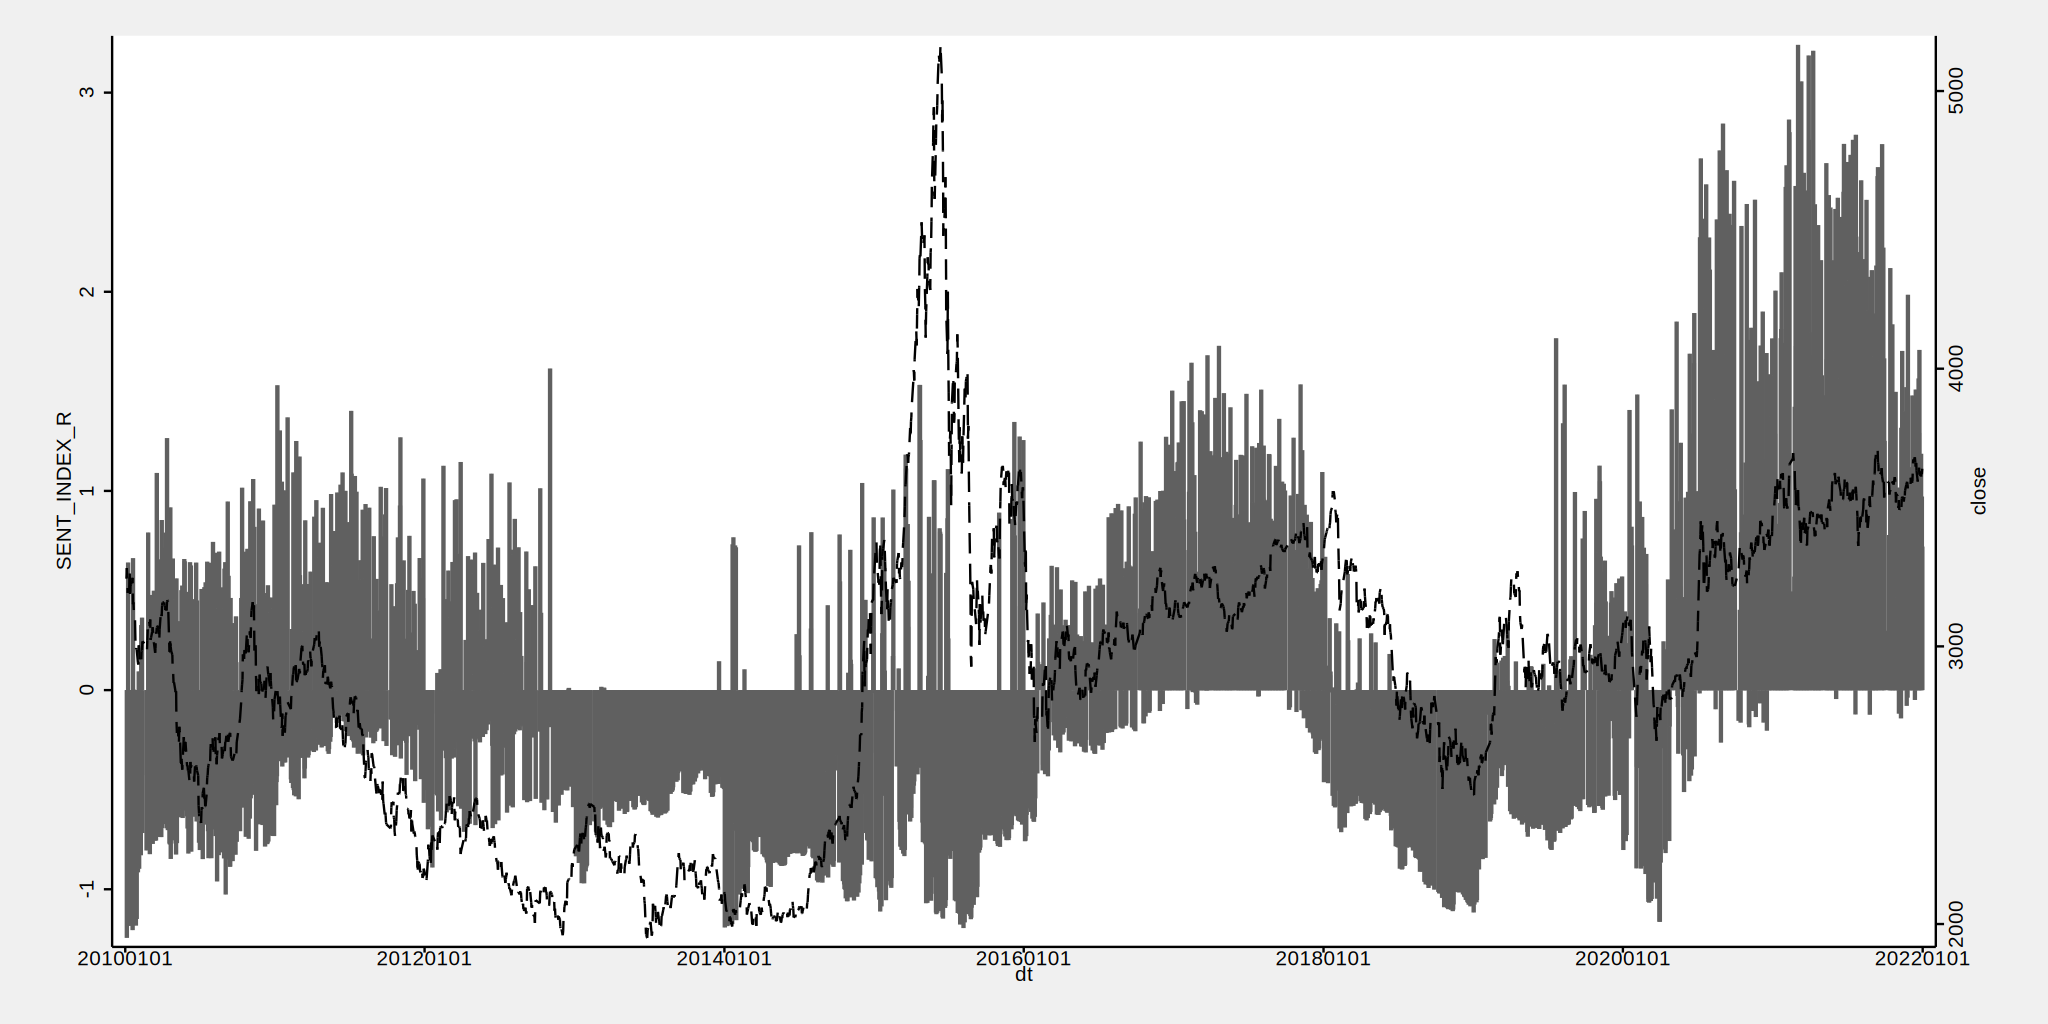

In [15]:
%%stata -gw 12in -gh 6in  -qui

//投资者情绪折线图
twoway bar  SENT_INDEX_R dt  || line close dt ,yaxis(2) ///
scheme(sj) legend(off) ylabel(, nogrid)  ///
name(sent_index_r ,replace)  scale(0.4)


In [16]:
df_sum = (
        pd.merge(
                pd.read_parquet('/data/DataSets/investor_sentiment/IDX_BAR_PANEL.parquet',
                                columns=['ts_code', 'close']).reset_index().query("ts_code=='000001.SH'&20100101<=trade_date<=20211231"),
                pd.merge(df_stata[['trade_date', 'SENT_INDEX']], df_stata_r[['trade_date', 'SENT_INDEX_R']], on='trade_date', how='left')
                .astype(dtype={'trade_date': 'uint64'}),
                on='trade_date', how='left'
        ))

In [17]:
df_sum

,trade_date,ts_code,close,SENT_INDEX,SENT_INDEX_R
0,20100104,000001.SH,3243.7600,8.988466e+307,8.988466e+307
1,20100105,000001.SH,3282.1790,-1.222655e+00,-1.244143e+00
2,20100106,000001.SH,3254.2150,3.961166e-02,-3.531558e-02
3,20100107,000001.SH,3192.7760,-8.297317e-01,-8.601315e-01
4,20100108,000001.SH,3195.9970,7.429671e-01,6.408601e-01
...,...,...,...,...,...
2912,20211227,000001.SH,3615.9741,5.972330e-01,3.905572e-01
2913,20211228,000001.SH,3630.1115,1.426782e+00,1.186737e+00
2914,20211229,000001.SH,3597.0002,2.028698e-01,1.338949e-02
2915,20211230,000001.SH,3619.1886,1.203630e+00,9.721268e-01
